# Traffic Data wrangling

This notebook contains the following aspects of the project
* [Traffic import and cleaning](#one): Create compiled CSVs using regex transformations of the very irregular and unstructured raw traffic data
* [NaNs Analysis](#two): NaN analysis for a station: recognises NaNs by forcing the frequency of the data to Hourly, then transforming the traffic into daily sums.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import matplotlib.dates as mdates

%matplotlib inline

# Plot formatting

# eye candy plots
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

warnings.filterwarnings('ignore')

In [36]:
sns.color_palette()

[(0.47843137254901963, 0.4627450980392157, 0.7607843137254902),
 (1.0, 0.43137254901960786, 0.611764705882353),
 (0.9647058823529412, 0.12941176470588237, 0.5882352941176471),
 (0.09411764705882353, 0.7529411764705882, 0.7686274509803922),
 (0.9529411764705882, 0.5647058823529412, 0.49411764705882355),
 (0.4, 0.9137254901960784, 0.9254901960784314)]

## 1. Traffic Import and Cleaning <a class="anchor" id="one"></a>

### Compile data from irregular, unstructured csv files

The table for each traffic counting station is unfortunately only available as a text file with irregular headings and an individual table for each day and counting station. Between each table are empty lines and text which varies. Furthermore, the tables are distributed across multiple csv files. These tables need to be concatenated to form a single table for each unique counting station across all dates. To do so run the script we developed from the terminal:

```> python csv-wrangling.py```

Or execture the cell below. You need access to the Traffic Data, which we do not have permission to upload to github.

The output file is called ```compiled-zählstellen.csv```

In [2]:
! (cd ..; python csv-wrangling.py)

Processing ./data/Anfrage_SWiesner_2012.csv
EOF, line:  177240
Processing ./data/Anfrage_SWiesner_2013.csv
EOF, line:  179130
Processing ./data/Anfrage_SWiesner_2014.csv
EOF, line:  225155
Processing ./data/Anfrage_SWiesner_2015.csv
EOF, line:  225120
Processing ./data/Anfrage_SWiesner_2016.csv
EOF, line:  222985
Processing ./data/Anfrage_SWiesner_2017.csv
EOF, line:  222845
Processing ./data/Anfrage_SWiesner_2018.csv
EOF, line:  255290
Processing ./data/Anfrage_SWiesner_2019.csv
EOF, line:  250845
Processing ./data/Anfrage_SWiesner_2020.csv
EOF, line:  231280
Processing ./data/Anfrage_SWiesner_2021.csv
EOF, line:  191870
Processing ./data/Anfrage_SWiesner_2022.csv
EOF, line:  211085


In [38]:
## Read complied csv into dataframe and parse Datetime
df = pd.read_csv("../data/compiled-zähstellen.csv", index_col=0, parse_dates=True)

In [39]:
## table contains the id of the counter "Zählstelle", cars (PKW) and trucks (LKW) as well as a total count (Gesamt)
df

,Zählstelle,PKW,LKW,Gesamt
datetime,,,,
2012-01-01 00:30:00,1013,168,11,179
2012-01-01 01:30:00,1013,359,20,379
2012-01-01 02:30:00,1013,989,17,1006
2012-01-01 03:30:00,1013,942,22,964
2012-01-01 04:30:00,1013,592,17,609
...,...,...,...,...
2022-04-06 19:30:00,3556,2552,508,3060
2022-04-06 20:30:00,3556,1519,324,1843
2022-04-06 21:30:00,3556,1268,269,1537


In [40]:
### Over a million datapoints of type integer
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1633641 entries, 2012-01-01 00:30:00 to 2022-04-06 23:30:00
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype
---  ------      --------------    -----
 0   Zählstelle  1633641 non-null  int64
 1   PKW         1633641 non-null  int64
 2   LKW         1633641 non-null  int64
 3   Gesamt      1633641 non-null  int64
dtypes: int64(4)
memory usage: 62.3 MB


### Visualising data and missing values <a class="anchor" id="two"></a>

We perform the analysis for a single station here, there are qualitatively simiar results for the other counting stations

In [41]:
### Choose the Zählstelle 
zähl = '1061'

### Filter for Zählstelle
df = df.query(f'Zählstelle == {zähl}').asfreq(freq="H").reset_index()
# df.Zählstelle[:] = zähl

##Drop unused columns
df.drop(['Zählstelle','PKW','LKW'],axis=1, inplace=True)

## Rename columns for Prophet
df.rename(columns={'Gesamt': 'y', 'datetime': 'ds'}, inplace=True)

### Which hours have NaNs?
df['NaN'] = df['y'].isna()

### Set the index again to 'ds' and make daily sums of traffic and hourly NaNs
df_daily = df.set_index('ds').resample('d').sum()

### If a day has more than 2 hourly NaNs, replace the day with nan
df_daily.loc[df_daily['NaN'] > 2,f'y'] = np.nan
df_daily.drop(f'NaN', axis=1,inplace=True)

## Overwrite dataframe of all Zählstellen with chosen Zählstelle in daily sums
df = df_daily.reset_index()

## Print head
df

,ds,y
0,2012-11-08,54836.0
1,2012-11-09,55398.0
2,2012-11-10,43370.0
3,2012-11-11,NaN
4,2012-11-12,53170.0
...,...,...
3701,2022-12-27,39152.0
3702,2022-12-28,37173.0
3703,2022-12-29,39667.0
3704,2022-12-30,39021.0


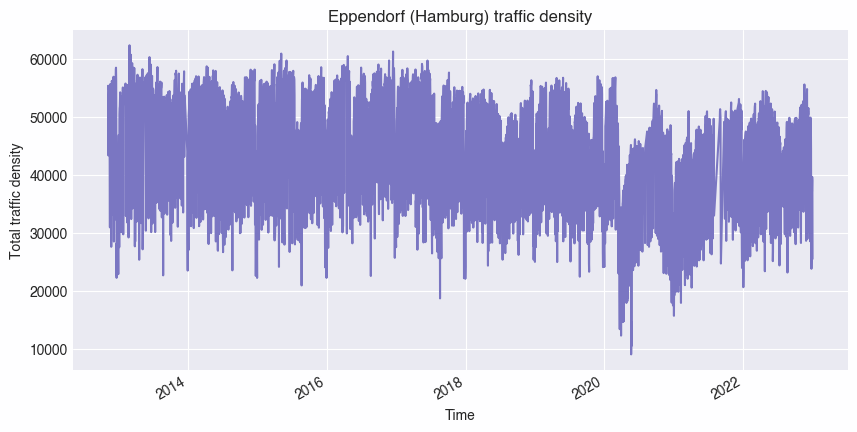

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(data=df,x='ds',
                   y='y',ax=ax);



fig.autofmt_xdate()
ax.set(xlabel='Time', ylabel='Total traffic density', title='Eppendorf (Hamburg) traffic density')

plt.show()


There is a notable crash in traffic around the first lockdown 

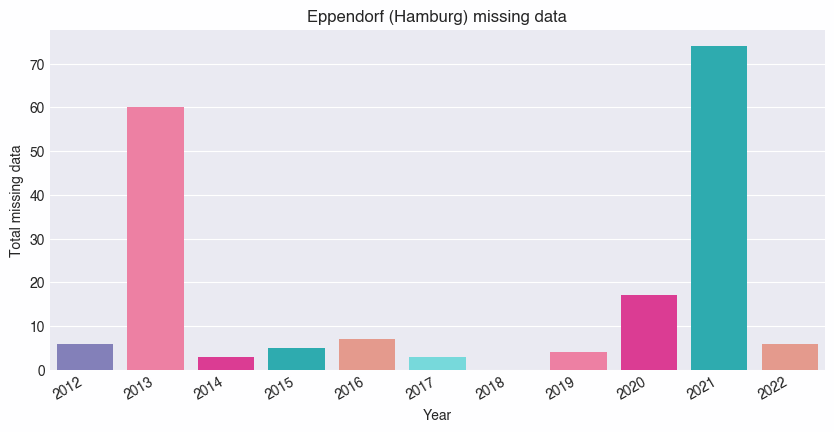

In [35]:
## Count NaNs
df['nan'] = df.y.isna()

## Number of NaNs per year
df['year'] = df.ds.dt.year

nans_yr = df.groupby('year',as_index=False).nan.sum()

## Plot the NaN sums
fig, ax = plt.subplots(figsize=(10,5))

sns.barplot(data=nans_yr, y='nan', x='year' , ax=ax, palette=sns.color_palette());

fig.autofmt_xdate()
ax.set(xlabel='Year', ylabel='Total missing data', title='Eppendorf (Hamburg) missing data')

plt.show()



There are multiple missing values spread across the data, with peaks in 2013 and 2021. NB: The data begins in November 2012 and ends on the last day of 2022. We need to either impute missing values or find a time-series model the can incorporate NaNs